# Comprehensive CCM Workflow Example

Demonstrates complete CCM analysis workflow with:
- Test data generation with known ground truth
- Preprocessing (detrending and normalization)
- Parameter optimization
- Parallel CCM analysis across pairs
- Surrogate testing
- Ground truth comparison
- Visualization

Based on: 011_ccm_analysis_norm_v3.ipynb and Surrogate Test 11-20-25.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns

from edmsystems.testdata import make_test_dataframe, get_ground_truth_network
from edmsystems.preprocessing import preprocess_for_ccm, inverse_preprocess
from edmsystems.ccm import run_ccm_workflow, summarize_results, compare_to_ground_truth

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
# Number of jobs
n_jobs = mp.cpu_count() // 4
print("Number of jobs: " + str(n_jobs))

Number of jobs: 32


## STEP 1: Generate test data with known ground truth

Generated data shape: (500, 20)
Columns: ['datetime', 'independent_X', 'independent_Y', 'correlated_X', 'correlated_Y', 'lagcorr_X', 'lagcorr_Y', 'autocorr_X', 'autocorr_Y', 'seasonal_X', 'seasonal_Y', 'unidirectional_X', 'unidirectional_Y', 'weak_causal_X', 'weak_causal_Y', 'bidirectional_X', 'bidirectional_Y', 'indirect_X', 'indirect_Z', 'indirect_Y']

Ground truth network shape: (19, 19)
True causal edges: 6



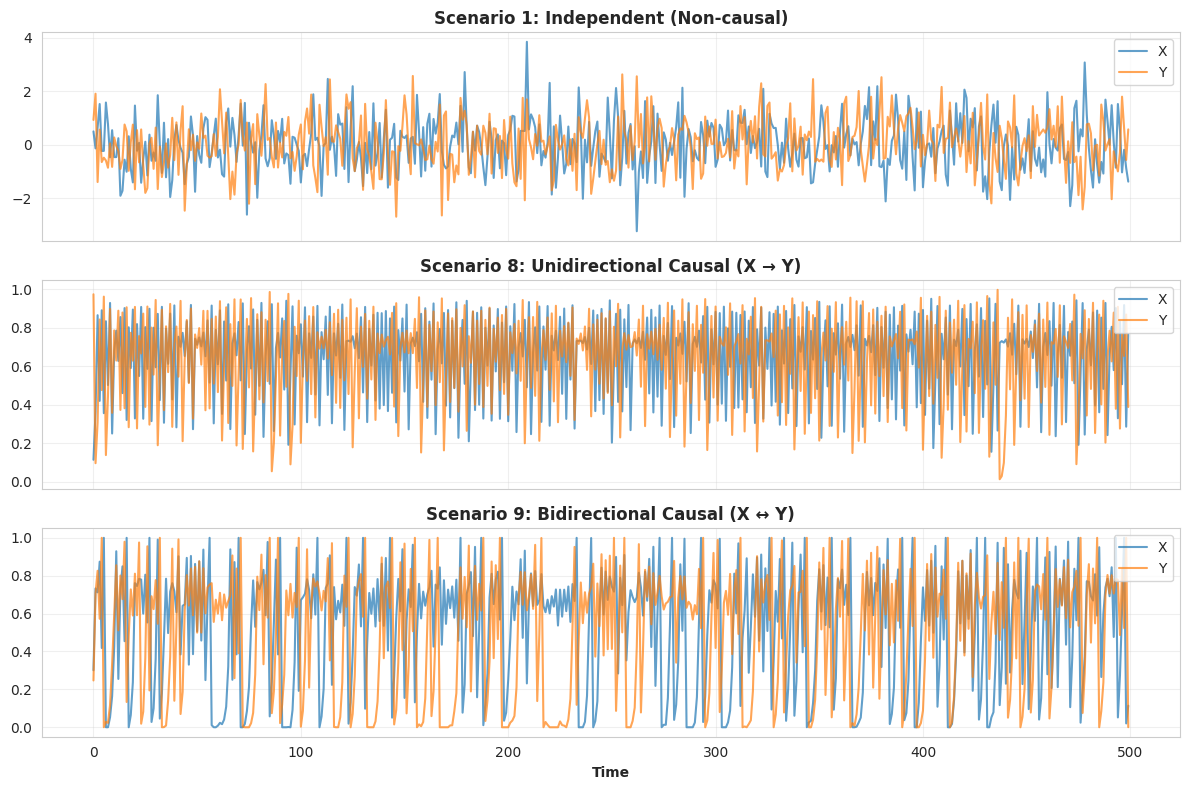

In [5]:
# Generate test data (10 scenarios, 500 time points)
df = make_test_dataframe(n=500, seed=42)
print(f"Generated data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Get ground truth network
truth_network = get_ground_truth_network()
print(f"\nGround truth network shape: {truth_network.shape}")
print(f"True causal edges: {truth_network.sum().sum()}")
print()


# Plot a subset of time series
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Independent (non-causal)
axes[0].plot(df['independent_X'], label='X', alpha=0.7)
axes[0].plot(df['independent_Y'], label='Y', alpha=0.7)
axes[0].set_title('Scenario 1: Independent (Non-causal)', fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Unidirectional causal (X → Y)
axes[1].plot(df['unidirectional_X'], label='X', alpha=0.7)
axes[1].plot(df['unidirectional_Y'], label='Y', alpha=0.7)
axes[1].set_title('Scenario 8: Unidirectional Causal (X → Y)', fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Bidirectional causal (X ↔ Y)
axes[2].plot(df['bidirectional_X'], label='X', alpha=0.7)
axes[2].plot(df['bidirectional_Y'], label='Y', alpha=0.7)
axes[2].set_title('Scenario 9: Bidirectional Causal (X ↔ Y)', fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('Time', fontweight='bold')

plt.tight_layout()
plt.show()

## STEP 2: Preprocess data

Preprocessed data shape: (500, 20)
Example stats (unidirectional_X): mean=0.000, std=0.999



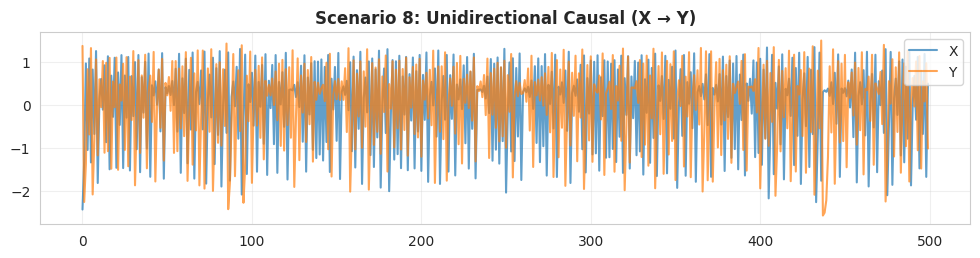

In [6]:
# Preprocess all variables (detrend + normalize)
preprocessed_data = {}
transform_params_dict = {}

variables = [col for col in df.columns if col != 'datetime']

for var in variables:
    processed, params = preprocess_for_ccm(
        df[var].values,
        detrend_method='linear',
        normalize_method='zscore'
    )
    preprocessed_data[var] = processed
    transform_params_dict[var] = params

# Create preprocessed dataframe
df_processed = pd.DataFrame(preprocessed_data)
df_processed.insert(0, 'time', range(len(df_processed)))

print(f"Preprocessed data shape: {df_processed.shape}")
print(f"Example stats (unidirectional_X): mean={np.mean(df_processed['unidirectional_X']):.3f}, std={np.std(df_processed['unidirectional_X']):.3f}")
print()


fig, axes = plt.subplots(1, 1, figsize=(12, 2.5), sharex=True)

# Independent (non-causal)
axes.plot(df_processed['unidirectional_X'], label='X', alpha=0.7)
axes.plot(df_processed['unidirectional_Y'], label='Y', alpha=0.7)
axes.set_title('Scenario 8: Unidirectional Causal (X → Y)', fontweight='bold')
axes.legend(loc='upper right')
axes.grid(True, alpha=0.3)

## STEP 4: Run CCM workflow

In [11]:
# Define specific pairs to test (or use None for all permutations)
test_pairs = [
    # Causal pairs (should be detected)
    ('unidirectional_X', 'unidirectional_Y'),
    ('bidirectional_X', 'bidirectional_Y'),
    ('bidirectional_Y', 'bidirectional_X'),
    ('weak_causal_X', 'weak_causal_Y'),

    # Non-causal pairs (should NOT be detected)
    ('independent_X', 'independent_Y'),
    ('correlated_X', 'correlated_Y'),
    ('lagcorr_X', 'lagcorr_Y'),
]

# Run CCM workflow with parallel processing
results = run_ccm_workflow(
    df_processed,
    pairs=test_pairs,
    auto_optimize=True,  # Optimize parameters per pair
    libSizes="50 400 50",
    sample=50,           # Random samples per library size
    n_surrogates=99,     # Twin surrogates for significance testing
    n_jobs=n_jobs,            # Parallel jobs (adjust based on CPU cores)
    seed=42,
    verbose=True
)

print()
print("Results:")
display(results)
print()

Testing 7 pairs...


CCM pairs: 100%|██████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.68it/s]


Results:


,lib,target,E,tau,Tp,theta,ccm_rho,convergence,ccm_norm,trial_rho95p,trial_rho99p,p_rho,resolved_nonlinear
0,unidirectional_X,unidirectional_Y,2,4,-2,0,NaN,False,NaN,NaN,NaN,NaN,False
1,bidirectional_X,bidirectional_Y,2,3,0,0,NaN,False,NaN,NaN,NaN,NaN,False
2,bidirectional_Y,bidirectional_X,2,3,-1,0,NaN,False,NaN,NaN,NaN,NaN,False
3,weak_causal_X,weak_causal_Y,2,8,-5,0,NaN,False,NaN,NaN,NaN,NaN,False
4,independent_X,independent_Y,2,1,-5,0,NaN,False,NaN,NaN,NaN,NaN,False
5,correlated_X,correlated_Y,6,1,0,0,NaN,False,NaN,NaN,NaN,NaN,False
6,lagcorr_X,lagcorr_Y,5,7,0,0,NaN,False,NaN,NaN,NaN,NaN,False


## STEP 5: Visualize results

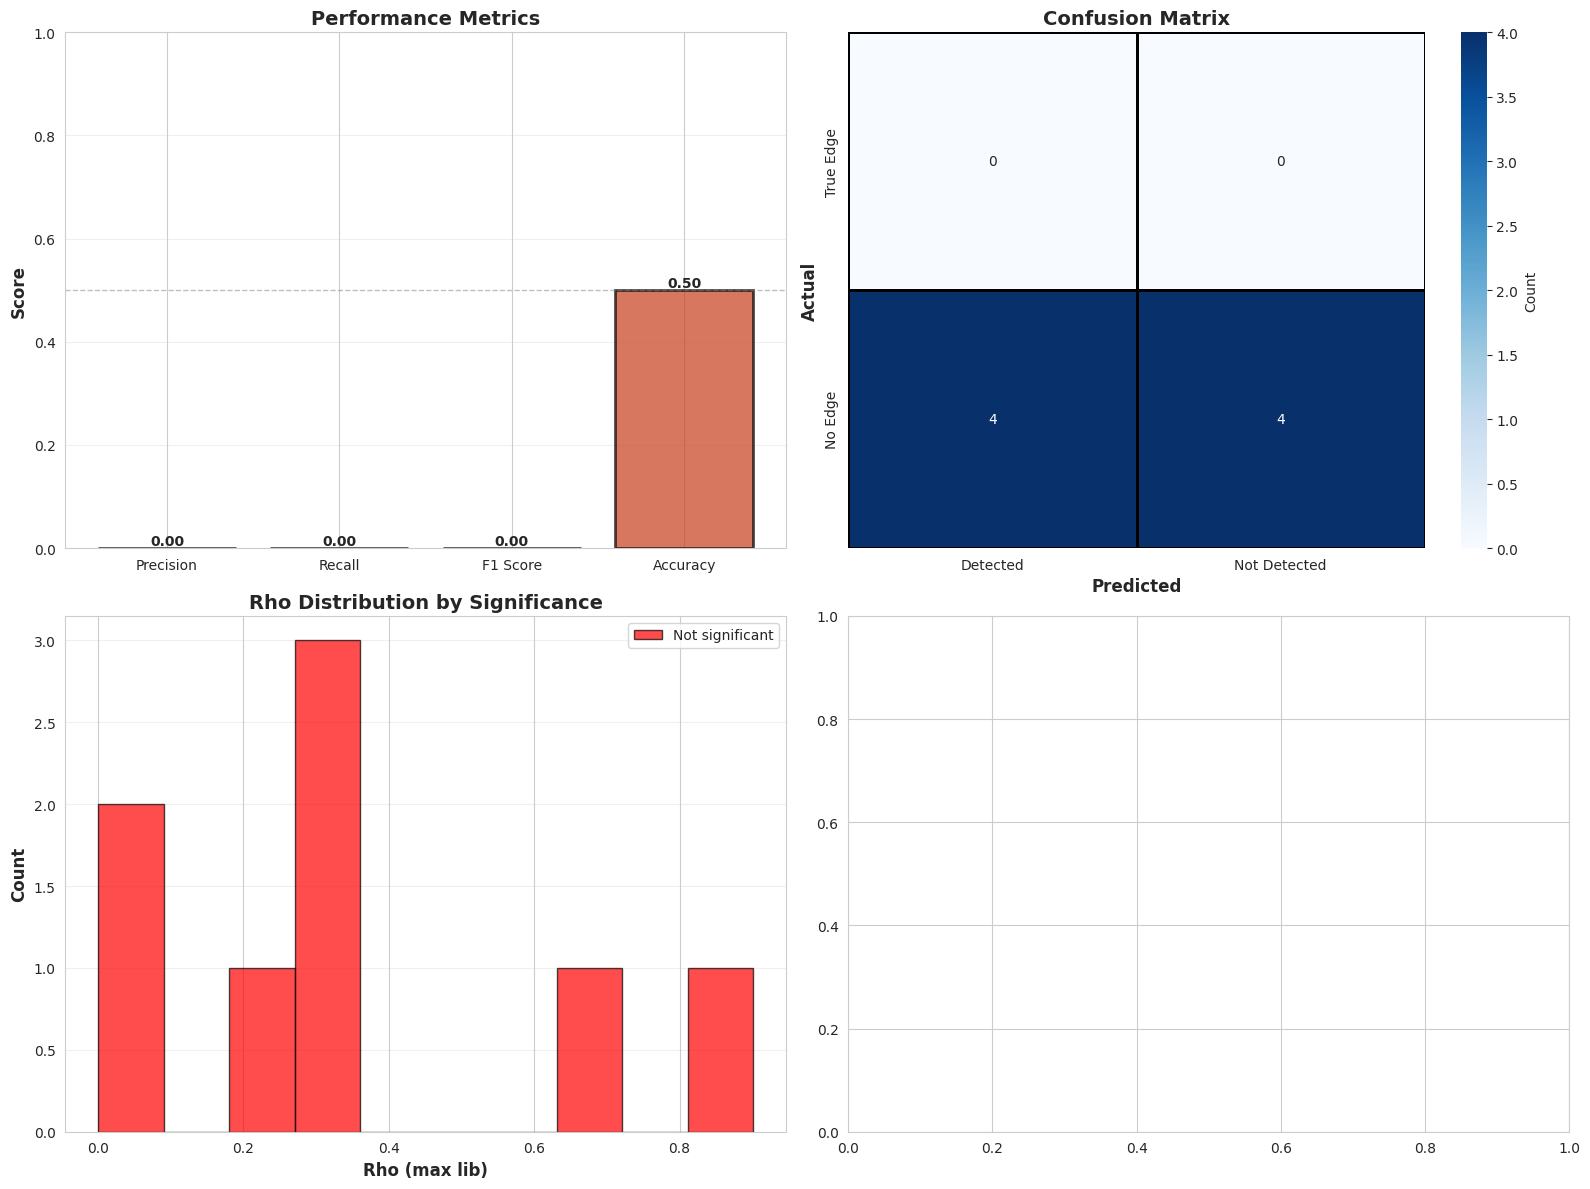

Exception ignored in: <function ResourceTracker.__del__ at 0x7f7ce5e21f80>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f4f58cadf80>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f70bf371f80>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multip

In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel A: Performance metrics
ax = axes[0, 0]
metrics = summary['performance_metrics']
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
metric_values = [metrics['precision'], metrics['recall'],
                metrics['f1_score'], metrics['accuracy']]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
bars = ax.bar(metric_names, metric_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontweight='bold')

# Panel B: Confusion matrix
ax = axes[0, 1]
confusion = np.array([[metrics['TP'], metrics['FP']],
                     [metrics['FN'], metrics['TN']]])
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Detected', 'Not Detected'],
            yticklabels=['True Edge', 'No Edge'],
            cbar_kws={'label': 'Count'},
            ax=ax, vmin=0, linewidths=2, linecolor='black')
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')

# Panel C: Rho distribution (detected vs non-detected)
ax = axes[1, 0]
detected = results[results['is_significant_twin']]['rho_original'].values
not_detected = results[~results['is_significant_twin']]['rho_original'].values

if len(detected) > 0:
    ax.hist(detected, bins=10, alpha=0.7, label='Significant',
            color='green', edgecolor='black')
if len(not_detected) > 0:
    ax.hist(not_detected, bins=10, alpha=0.7, label='Not significant',
            color='red', edgecolor='black')

ax.set_xlabel('Rho (max lib)', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Rho Distribution by Significance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()